### Собственное решение XGBoost + Optuna

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import datetime
import gc

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
INPUT_DIR = '/kaggle/input/ieee-fraud-detection'
TARGET = 'isFraud'

# Загрузка данных

In [4]:
train_transaction = pd.read_csv(f'{INPUT_DIR}/train_transaction.csv')
test_transaction = pd.read_csv(f'{INPUT_DIR}/test_transaction.csv')

train_identity = pd.read_csv(f'{INPUT_DIR}/train_identity.csv')
test_identity = pd.read_csv(f'{INPUT_DIR}/test_identity.csv')

sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [5]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

print(f'Train size: {train.shape}\nTest size: {test.shape}')

Train size: (590540, 434)
Test size: (506691, 433)


In [6]:
test.rename(columns={'id-01': 'id_01', 'id-02': 'id_02', 'id-03': 'id_03', 
                                  'id-04': 'id_04', 'id-05': 'id_05', 'id-06': 'id_06', 
                                  'id-07': 'id_07', 'id-08': 'id_08', 'id-09': 'id_09', 
                                  'id-10': 'id_10', 'id-11': 'id_11', 'id-12': 'id_12', 
                                  'id-13': 'id_13', 'id-14': 'id_14', 'id-15': 'id_15', 
                                  'id-16': 'id_16', 'id-17': 'id_17', 'id-18': 'id_18', 
                                  'id-19': 'id_19', 'id-20': 'id_20', 'id-21': 'id_21', 
                                  'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24',
                                  'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 
                                  'id-28': 'id_28', 'id-29': 'id_29', 'id-30': 'id_30', 
                                  'id-31': 'id_31', 'id-32': 'id_32', 'id-33': 'id_33', 
                                  'id-34': 'id_34', 'id-35': 'id_35', 'id-36': 'id_36', 
                                  'id-37': 'id_37', 'id-38': 'id_38'}, inplace=True)

In [11]:
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

y_train = train['isFraud'].copy()

del train_transaction, train_identity, test_transaction, test_identity, train, test
gc.collect()

1168

# Предобработка данных

In [13]:
def fraud_datetime(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

    df['dow'] = df['TransactionDT'].dt.dayofweek
    df['hour'] = df['TransactionDT'].dt.hour
    df.drop(['TransactionDT'],axis=1,inplace=True)
    return df

In [12]:
# %%time
# X_train["null_counts"] = X_train.isna().sum(axis=1)
# X_test["null_counts"] = X_test.isna().sum(axis=1)

# X_train["nuniques"] = X_train.select_dtypes(include=[np.number]).nunique(axis=1)
# X_test["nuniques"] = X_test.select_dtypes(include=[np.number]).nunique(axis=1)

CPU times: user 1min 8s, sys: 2.01 s, total: 1min 10s
Wall time: 1min 10s


In [14]:
X_train = fraud_datetime(X_train).fillna(-999)
X_test = fraud_datetime(X_test).fillna(-999)

Label encoding

In [15]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 

In [16]:
X_train.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,dow,hour
0,2987000,68.5,4,13926,-999.0,150.0,2,142.0,2,315.0,...,0,0,0,0,0,0,0,0,5,0
1,2987001,29.0,4,2755,404.0,150.0,3,102.0,2,325.0,...,0,0,0,0,0,0,0,0,5,0
2,2987002,59.0,4,4663,490.0,150.0,4,166.0,3,330.0,...,0,0,0,0,0,0,0,0,5,0
3,2987003,50.0,4,18132,567.0,150.0,3,117.0,3,476.0,...,0,0,0,0,0,0,0,0,5,0
4,2987004,50.0,1,4497,514.0,150.0,3,102.0,2,420.0,...,269,4,2,1,2,2,2,1566,5,0


In [17]:
gc.collect()

1626

# Обучающая и валидационная выборка

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,
    random_state=RANDOM_STATE)

print(f'Data splitted. Parts sizes: train = {X_train.shape}, val = {X_val.shape}')

Data splitted. Parts sizes: train = (501959, 434), val = (88581, 434)


# Обучение модели

In [19]:
def opt(X_train, y_train, X_test, y_test, trial):
    n_estimators = trial.suggest_int('n_estimators', 400, 600)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)

    xgboost_tuna = xgb.XGBClassifier(
        n_jobs=4, 
        learning_rate=0.05,
        random_state=RANDOM_STATE,
        missing=-999,
        tree_method = "hist", 
        device = "cuda",
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample, 
        colsample_bytree = colsample_bytree)

    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test_proba = xgboost_tuna.predict_proba(X_test)[:,1]

    return roc_auc_score(y_test, tuna_pred_test_proba)

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(functools.partial(opt, X_train, y_train, X_val, y_val), n_trials=50)

[I 2023-12-27 19:09:54,494] A new study created in memory with name: no-name-bbd6dfe7-d070-4676-a918-8183c5979261
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:10:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2023-12-27 19:10:37,743] Trial 0 finished with value: 0.9550769358274286 and parameters: {'n_estimators': 532, 'max_depth': 7, 'subsample': 0.8846815918525442, 'colsample_bytree': 0.8805362271532445}. Best is trial 0 with value: 0.9550769358274286.
[I 2023-12-27 19:11:17,800] Trial 1 finished with value: 0.9556197867431371 an

In [21]:
print("Best score:",study.best_value)
print(study.best_params)

Best score: 0.9742470325691605
{'n_estimators': 597, 'max_depth': 10, 'subsample': 0.7361497792481181, 'colsample_bytree': 0.9218694600790023}


In [22]:
clf = xgb.XGBClassifier(**study.best_params, 
                        random_state=RANDOM_STATE,
                        learning_rate=0.05,
                        n_jobs=4,
                        missing=-999,
                        tree_method = "hist", 
                        device = "cuda")

X_train = pd.concat([X_train,X_val])
y_train = pd.concat([y_train,y_val])

print(X_train.shape)
print(y_train.shape)

(590540, 434)
(590540,)


In [23]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9218694600790023, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=-999, monotone_constraints=None,
              multi_strategy=None, n_estimators=597, n_jobs=4,
              num_parallel_tree=None, random_state=42, ...)

# Submission

In [24]:
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('manual_xgb_submission.csv', index=False)

Текущее решение

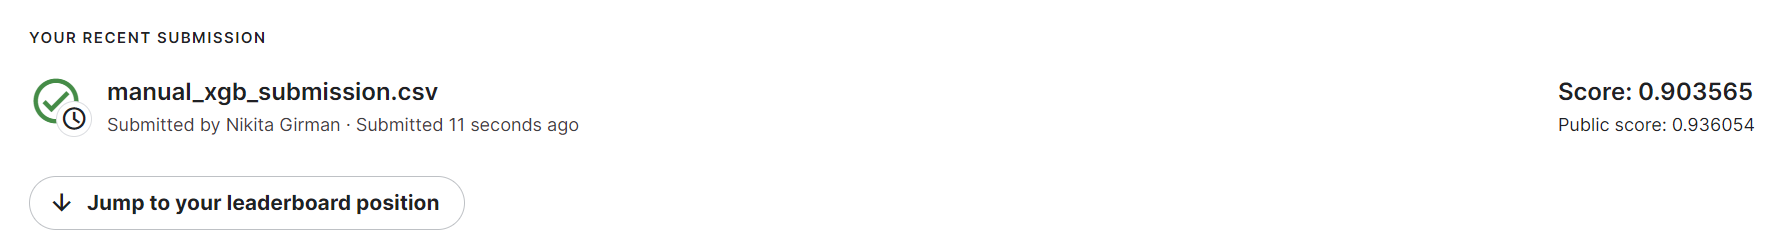

Решения LightAutoML

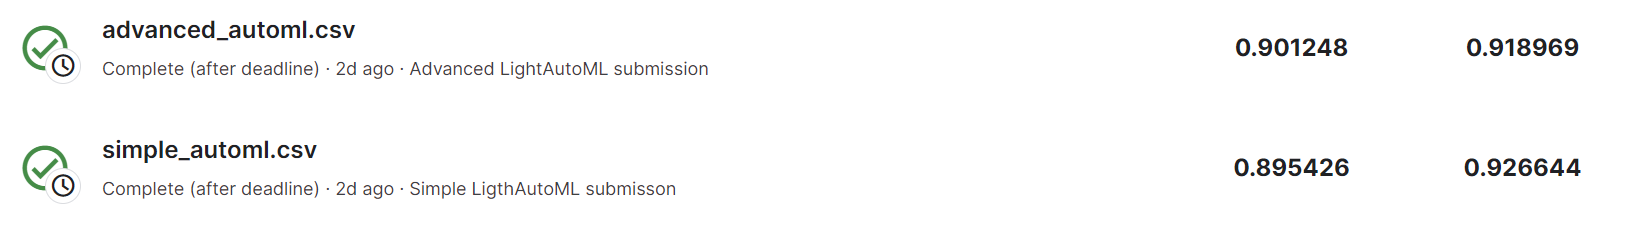

Итог: скор LightAutoML побит (не с первого раза)